# Workshop on Person verification in surveillance using feature extraction and learning

Course: Vision Systems

Website: https://www.iss.nus.edu.sg/executive-education/course/detail/vision--systems/artificial-intelligence

Contact: Tian Jing

Email: tianjing@nus.edu.sg

## Objective
In this workshop, we will perform the following four tasks
- Build a person verification model using feature extraction method 
- Build a machine learning model for person verification using siamese networks
- Apply the person verification model on a large dataset to find the most similar image given the query image

## Submission guideline

Once you finish the workshop, rename your .ipynb file to be your name, and submit your .ipynb file into LumiNUS.

## Dataset

- We will use *Labeled Faces in the Wild* (LFW) dataset, specifically, `All images aligned with deep funneling`, http://vis-www.cs.umass.edu/lfw/lfw-deepfunneled.tgz (111 MB). More information can be found at the original dataset website at http://vis-www.cs.umass.edu/lfw/

## Note
- For demonstration purposes, we will only use a subset of the dataset in this workshop. The whole dataset contains 5749 persons (folders).
- To reduce the time required in model training in this workshop, we will build a simple convolutional neural network model.
- The Siamese network using Keras subclassing example: https://github.com/dongxiaohuang/Tensorflow2.0_notes/blob/main/tf2_siamese_network.ipynb


In [1]:
# Load library
import cv2
import tensorflow.keras.backend as K
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Input, Lambda, Dot, Conv2D, MaxPool2D, Flatten
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline

import tensorflow as tf
print("Tensorflow version: ", tf.__version__)
print(tf.test.gpu_device_name())
# Your expected output will be '/device:GPU:0'


Tensorflow version:  2.6.0
/device:GPU:0


In [2]:
# Grant access to google drive.
# Run this cell, then you’ll see a link, click on that link, allow access
# Copy the code that pops up, paste it in the box, hit Enter

from google.colab import drive
drive.mount('/content/gdrive')

# Change working directory to be current folder, please keep ''/content/gdrive/My Drive/XXX' in the path
# and change XXX to be your own folder. The pathname is case sensitive.
import os
os.chdir('/content/gdrive/MyDrive/iss/VSE/person')
!ls


Mounted at /content/gdrive
bill1.jpg  wk_person_verification_keras_v202107.ipynb	 yao1.jpg
data	   wk_person_verification_pytorch_v202107.ipynb  yao2.jpg


# Exercise 1: Evaluate similarity of two person image using HoG feature extraction method

Objective: Given two person images, extract their HoG features and calculate their cosine similarity (larger value indicates higher similarity)

The similarity of two images is 0.7275


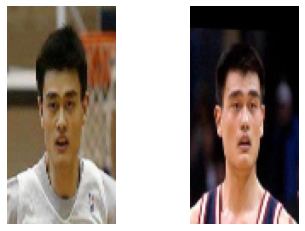

In [3]:
# Define the configuration of HoG feature extraction

# Resize the input image to a fixed resolution for feature extraction
IMG_HEIGHT = 128
IMG_WIDTH = 64

# Block size, Cell size, Stride size, Number of bins as defined in HoG.
blockSize = (16, 16)
blockStride = (8, 8)
cellSize = (8, 8)
nbins = 9

# Step 1: Load images and resize images
test_image1 = cv2.imread('yao2.jpg')
test_image2 = cv2.imread('yao1.jpg')

test_image1 = cv2.resize(test_image1, (IMG_WIDTH, IMG_HEIGHT))
test_image2 = cv2.resize(test_image2, (IMG_WIDTH, IMG_HEIGHT))

# Step 2: Extract HoG features
hog = cv2.HOGDescriptor((IMG_WIDTH, IMG_HEIGHT), blockSize, blockStride, cellSize, nbins)
test_image1_hog = hog.compute(test_image1)
test_image2_hog = hog.compute(test_image2)

# Step 3: Normalize the HoG features and calculate their cosine similarity distance
test_image1_hog = test_image1_hog/np.linalg.norm(test_image1_hog)
test_image2_hog = test_image2_hog/np.linalg.norm(test_image2_hog)

sims = np.inner(np.transpose(test_image1_hog), np.transpose(test_image2_hog))
print('The similarity of two images is %.4f' % sims)

# Display the input images
plt.figure()
plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(test_image1, cv2.COLOR_BGR2RGB) / 255)
plt.axis('off')
plt.subplot(1, 2, 2)
plt.imshow(cv2.cvtColor(test_image2, cv2.COLOR_BGR2RGB) / 255)
plt.axis('off')
plt.show()

# Explore LFW face dataset

The dataset consists of folders corresponding to each person. The folder name is the name of the person.

First, we map each class (identity) to an integer id, and build mappings as dictionaries.
- mappings from person name (folder name) and class id: `name_to_classid` and `classid_to_name`

Furthermore, in each folder, there is one or more images corresponding to the identity. We map each image path with an integer id, then build a few dictionaries
- mappings from imagepath and image id: `path_to_imageid` and `imageid_to_path`
- mappings from class id to image id: `classid_to_imageid` and `imageid_to_classid`

Summary 
- name: person name, folder name
- classid: integer number to indicate the person name
- path: path to save the person images
- imageid: integer number to indicate the image file index

In [4]:
# Define the path for the downloaded images
PATH = "data/"
dirs = sorted(os.listdir(PATH))

# Build two dictionaries
name_to_classid = {d: i for i, d in enumerate(dirs)}
classid_to_name = {v: k for k, v in name_to_classid.items()}

# read all directories
img_paths = {c: [PATH + subfolder + "/" + img
                 for img in sorted(os.listdir(PATH + subfolder))] 
             for subfolder, c in name_to_classid.items()}

# retrieve all images
all_images_path = []
for img_list in img_paths.values():
    all_images_path += img_list

# map to integers
path_to_imageid = {v: k for k, v in enumerate(all_images_path)}
imageid_to_path = {v: k for k, v in path_to_imageid.items()}

# build mappings between images and class
classid_to_imageid = {k: [path_to_imageid[path] for path in v] for k, v in img_paths.items()}
imageid_to_classid = {v: c for c,imgs in classid_to_imageid.items() for v in imgs}

print("Total number of classes (persons) in workshop: ", len(classid_to_imageid))
print("Total number of images (files) in workshop: ", len(imageid_to_classid))

Total number of classes (persons) in workshop:  50
Total number of images (files) in workshop:  261


# Prepare dataset to train a deep learning model for person verification

- Build pairs of positive and negative training images
- Split dataset into train and test subsets for model training


In [5]:
# build pairs of positive image ids for a given classid
def build_pos_pairs_imageid(classid, max_num=5):
    imgs = classid_to_imageid[classid]
    if len(imgs) == 1:
        return []
    pos_pairs = [(imgs[i], imgs[j])
                 for i in range(len(imgs))
                 for j in range(i + 1, len(imgs))]
    random.shuffle(pos_pairs)
    return pos_pairs[:max_num]

# build pairs of negative image ids for a given classid
def build_neg_pairs_imageid(classid, classes, max_num=5):
    imgs = classid_to_imageid[classid]
    neg_classes_imageid = random.sample(classes, max_num+1)
    if classid in neg_classes_imageid:
        neg_classes_imageid.remove(classid)
    neg_pairs = []
    for id2 in range(max_num):
        img1 = imgs[random.randint(0,len(imgs)-1)]
        imgs2 = classid_to_imageid[neg_classes_imageid[id2]]
        img2 = imgs2[random.randint(0,len(imgs2)-1)]
        neg_pairs += [(img1, img2)]
    return neg_pairs

def open_all_images(id_to_path):
    all_imgs = []
    for path in id_to_path.values():
        temp = cv2.imread(path)
        temp = cv2.resize(temp, (100, 100)).astype('float32') # convert image into float32 
        all_imgs += [np.expand_dims(temp,0)]
    return np.vstack(all_imgs)

def build_train_test_data(num_classes, split=0.8):
    listX1 = []
    listX2 = []
    listY = []
    split = int(num_classes * split)
    
    # train
    for id in range(split):
        pos = build_pos_pairs_imageid(id)
        neg = build_neg_pairs_imageid(id, list(range(split)))
        for pair in pos:
            listX1 += [pair[0]]
            listX2 += [pair[1]]
            listY += [1]
        for pair in neg:
            listX1 += [pair[0]]
            listX2 += [pair[1]]
            listY += [0]
    perm = np.random.permutation(len(listX1))
    X1_ids_train = np.array(listX1)[perm]
    X2_ids_train = np.array(listX2)[perm]
    Y_ids_train = np.array(listY)[perm]
    
    listX1 = []
    listX2 = []
    listY = []
    
    # test
    for id in range(split, num_classes):
        pos = build_pos_pairs_imageid(id)
        neg = build_neg_pairs_imageid(id, list(range(split, num_classes)))
        for pair in pos:
            listX1 += [pair[0]]
            listX2 += [pair[1]]
            listY += [1]
        for pair in neg:
            listX1 += [pair[0]]
            listX2 += [pair[1]]
            listY += [0]
    X1_ids_test = np.array(listX1)
    X2_ids_test = np.array(listX2)
    Y_ids_test = np.array(listY)
    return (X1_ids_train, X2_ids_train, Y_ids_train.astype('float32'), X1_ids_test, X2_ids_test, Y_ids_test.astype('float32'))

# Build a custom dataset generator, https://stanford.edu/~shervine/blog/keras-how-to-generate-data-on-the-fly

class CustomDataGen(tf.keras.utils.Sequence):
    
    def __init__(self, X1, X2, Y, batch_size, all_imgs):
        
        self.batch_size = batch_size
        self.X1 = X1
        self.X2 = X2
        self.Y = Y
        self.imgs = all_imgs
        self.num_samples = Y.shape[0]
        self.indexes = np.arange(self.num_samples)
    
    def on_epoch_end(self):
        np.random.shuffle(self.indexes)
    
    def __getitem__(self, index):
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]
        imgs1 = self.X1[indexes]
        imgs2 = self.X2[indexes]

        return [self.imgs[imgs1], self.imgs[imgs2]], self.Y[indexes]
   
    def __len__(self):
        return int(np.floor(self.num_samples / self.batch_size))

# train pairs (400,) (400,) (400,) # test pairs (100,) (100,) (100,)
Total images:  (261, 100, 100, 3)


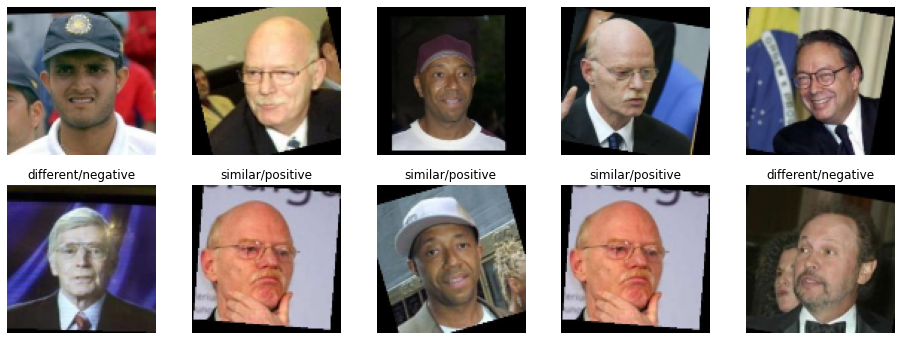

In [6]:
# Generate training imageid index and test imageid index
num_classes = len(name_to_classid) # Total number of persons used in this workshop
X1_ids_train, X2_ids_train, train_Y, X1_ids_test, X2_ids_test, test_Y = build_train_test_data(num_classes)
print('# train pairs', X1_ids_train.shape, X2_ids_train.shape, train_Y.shape, '# test pairs', X1_ids_test.shape, X2_ids_test.shape, test_Y.shape)

# Open all images
all_imgs = open_all_images(imageid_to_path)
print('Total images: ', all_imgs.shape)

# Build a dataloader (to create batches)
myGenerator = CustomDataGen(X1_ids_train, X2_ids_train, train_Y, 32, all_imgs)

# Display a few pairs of training images
[x1, x2], y = myGenerator[0]

plt.figure(figsize=(16, 6))
for i in range(5):
    plt.subplot(2, 5, i + 1)
    plt.imshow(cv2.cvtColor(x1[i], cv2.COLOR_BGR2RGB) / 255) # Convert image color format, as Opencv load image in BGR format
    plt.axis('off')
for i in range(5):
    plt.subplot(2, 5, i + 6)
    plt.imshow(cv2.cvtColor(x2[i], cv2.COLOR_BGR2RGB) / 255)
    if y[i]==1.0:
        plt.title("similar/positive")
    else:
        plt.title("different/negative")
    plt.axis('off')
plt.show()

# Prepare test image subset
test_X1 = all_imgs[X1_ids_test]
test_X2 = all_imgs[X2_ids_test]

# Exercise 2: Design and train a person verification model

Objectives: Build a convolutional model.
 
Warning: Large convolutions on high dimensional images can be very slow on CPUs.

In [7]:
class BaseCNNNetwork(tf.keras.models.Model):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        self.conv1 = Conv2D(16, (3,3), activation="relu", padding="same")
        self.conv2 = Conv2D(16, (3,3), activation="relu", padding="same")
        self.pool = MaxPool2D(pool_size=(2,2))
        self.flatten = Flatten()
        self.dense = Dense(50, activation="relu")
    
    def call(self, input_):
        output = self.conv1(input_)
        output = self.conv2(output)
        output = self.pool(output)
        output = self.flatten(output)
        output = self.dense(output)
        return output

    def build_graph(self, input_shape):
        input_ = Input(shape=input_shape)
        return Model(inputs=[input_], outputs=self.call(input_))     

In [8]:
shared_conv = BaseCNNNetwork()
shared_conv.build_graph((100,100,3)).summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 100, 100, 3)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 100, 100, 16)      448       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 100, 100, 16)      2320      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 50, 50, 16)        0         
_________________________________________________________________
flatten (Flatten)            (None, 40000)             0         
_________________________________________________________________
dense (Dense)                (None, 50)                2000050   
Total params: 2,002,818
Trainable params: 2,002,818
Non-trainable params: 0
___________________________________________________

In [9]:
def euclidean_distance(vects):
    x, y = vects
    sum_square = K.sum(K.square(x - y), axis=1, keepdims=True)
    return K.sqrt(K.maximum(sum_square, K.epsilon()))

def eucl_dist_output_shape(shapes):
    shape1, shape2 = shapes
    return (shape1[0], 1)

# create customized layer
class CustomizedEuclideanDistanceLayer(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
    
    def build(self, input_shape):
        super().build(input_shape)
    
    def call(self, inputs):
        return euclidean_distance(inputs)
        
euclidean_dis_layer_cus = CustomizedEuclideanDistanceLayer(name='output_layer')

In [10]:
class SiameseModel(tf.keras.models.Model):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        self.base_model = BaseCNNNetwork()
        self.euclidean_dis_layer = Lambda(euclidean_distance, name="outpur_layer", output_shape=eucl_dist_output_shape)
    
    def call(self, inputs):
        input_1, input_2 = inputs
        embedding1 = self.base_model(input_1)
        embedding2 = self.base_model(input_2)

        output = self.euclidean_dis_layer([embedding1, embedding2])
        return output
        
    def build_graph(self, input_shape):
        input_1 = Input(shape=input_shape)
        input_2 = Input(shape=input_shape)
        return Model(inputs=[input_1, input_2], outputs=self.call([input_1, input_2]))    

model = SiameseModel()
# Build the model with dummy data and display model summary
model.build_graph((100,100,3)).summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 100, 100, 3) 0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            [(None, 100, 100, 3) 0                                            
__________________________________________________________________________________________________
base_cnn_network_1 (BaseCNNNetw (None, 50)           2002818     input_2[0][0]                    
                                                                 input_3[0][0]                    
__________________________________________________________________________________________________
outpur_layer (Lambda)           (None, 1)            0           base_cnn_network_1[0][0]   

In [11]:
# Define the loss function
def contrastive_loss(y_true, y_pred, margin=0.25):
    '''Contrastive loss from Hadsell-et-al.'06
    http://yann.lecun.com/exdb/publis/pdf/hadsell-chopra-lecun-06.pdf
    '''
    return K.mean( y_true * K.square(1 - y_pred) + (1 - y_true) * K.square(K.maximum(y_pred - margin, 0)))

In [12]:
NUM_EPOCH = 40
model.compile(loss=contrastive_loss, optimizer='adam')
hist = model.fit(myGenerator, steps_per_epoch=train_Y.shape[0] // 32, epochs=NUM_EPOCH, validation_data=([test_X1, test_X2], test_Y), verbose=1)

Epoch 1/40
12/12 [==============================] - 4s 88ms/step - loss: 5337.8120 - val_loss: 0.4997
Epoch 2/40
12/12 [==============================] - 1s 45ms/step - loss: 0.4971 - val_loss: 0.4997
Epoch 3/40
12/12 [==============================] - 1s 46ms/step - loss: 0.4945 - val_loss: 0.4997
Epoch 4/40
12/12 [==============================] - 1s 47ms/step - loss: 0.5049 - val_loss: 0.4997
Epoch 5/40
12/12 [==============================] - 1s 47ms/step - loss: 0.4945 - val_loss: 0.4997
Epoch 6/40
12/12 [==============================] - 1s 46ms/step - loss: 0.5127 - val_loss: 0.4997
Epoch 7/40
12/12 [==============================] - 1s 45ms/step - loss: 0.5023 - val_loss: 0.4997
Epoch 8/40
12/12 [==============================] - 1s 46ms/step - loss: 0.4919 - val_loss: 0.4997
Epoch 9/40
12/12 [==============================] - 1s 45ms/step - loss: 0.4997 - val_loss: 0.4997
Epoch 10/40
12/12 [==============================] - 1s 46ms/step - loss: 0.5049 - val_loss: 0.4997
Epoch 

The similarity of two images is 0.6749


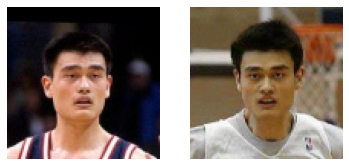

In [13]:
# Step 1: Load images and resize images
test_image1 = cv2.imread('yao1.jpg')
test_image2 = cv2.imread('yao2.jpg')
#test_image2 = cv2.imread('bill1.jpg')

# Load image, convert image color format, change the shape of the image, the input should be converted into .astype('float32') format
test_image1 = cv2.resize(test_image1, (100, 100)).astype('float32')
test_image2 = cv2.resize(test_image2, (100, 100)).astype('float32')

# Step 2: Extract features using the pre-trained siamese model
# Note: need to expand the input image to be 4D to fit into the model
test_image1_coeff = shared_conv.predict(np.expand_dims(test_image1, 0))
test_image2_coeff = shared_conv.predict(np.expand_dims(test_image2, 0))

# Step 3: Normalize features and calculate their cosine similarity distance
# Normalize by L2-norm https://docs.scipy.org/doc/numpy/reference/generated/numpy.linalg.norm.html

sims = np.inner(test_image1_coeff/np.linalg.norm(test_image1_coeff), test_image2_coeff/np.linalg.norm(test_image2_coeff))
print('The similarity of two images is %.4f' % sims)

# Plot the two given images
plt.figure()
plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(test_image1, cv2.COLOR_BGR2RGB) / 255)
plt.axis('off')
plt.subplot(1, 2, 2)
plt.imshow(cv2.cvtColor(test_image2, cv2.COLOR_BGR2RGB) / 255)
plt.axis('off')
plt.show()

# Exercise 3: Apply the person verification model to find the most similar image given the query image


$\color{red}{\text{Q1. Complete the code to build an image similarity evaluation model.}}$

Tasks

- Randomly select a query image, apply the person verification model to find similar images from the data `all_imgs`
- Evaluate the similairty using the pre-trained siamese model
- Display the query image, top three similar images, and their respective confidence score.

In [14]:
def check(test_image1):
  test_image1 = cv2.resize(test_image1, (100, 100)).astype('float32')

  test_image1_coeff = shared_conv.predict(np.expand_dims(test_image1, 0))

  d={}
  for i,test_image2 in enumerate(all_imgs):
    test_image2 = cv2.resize(test_image2, (100, 100)).astype('float32')
    test_image2_coeff = shared_conv.predict(np.expand_dims(test_image2, 0))
    sims = np.inner(test_image1_coeff/np.linalg.norm(test_image1_coeff), test_image2_coeff/np.linalg.norm(test_image2_coeff))[0][0]
    d[i]=sims

  d=dict(sorted(d.items(), key=lambda item: item[1],reverse = True))  
  first_three = list(d.items())[:3]
  print(first_three)
  
  x = [i[0] for i in first_three]
  y = [i[1] for i in first_three]

  # Plot the two given images
  
  plt.imshow(cv2.cvtColor(test_image1, cv2.COLOR_BGR2RGB) / 255)

  plt.figure()
  for i in range(1,4):
    plt.subplot(1, 3, i)
    plt.imshow(cv2.cvtColor(all_imgs[x[i-1]], cv2.COLOR_BGR2RGB) / 255)
    plt.axis('off')
  plt.show()

  print(y)

[(141, 0.9167799), (215, 0.9067876), (28, 0.9009545)]


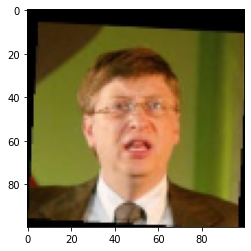

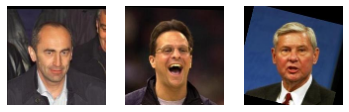

[0.9167799, 0.9067876, 0.9009545]


In [15]:
# check with given test image
im = cv2.imread('bill1.jpg')
check(im)

[(114, 1.0000001), (105, 0.8487553), (141, 0.83689845)]


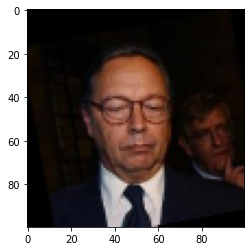

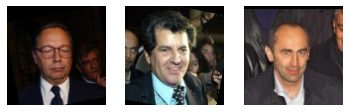

[1.0000001, 0.8487553, 0.83689845]


In [16]:
# check with a random image from all_imgs
im = random.choice(all_imgs)
check(im)

$\color{red}{\text{Q2. Propose how to further boost the accuracy performance of the person verification model used in this workshop.}}$

For example: Apply the face detection on the input image, then use detected face as training data, instead of using the whole image as training data.


Currently Base CNN model in Siamese network has only 2 conv, 1 pooling and 1 dense layers. Tune hyperparameters like:
1. no. of filters, 
2. size of filters, 
3. no. of dense layers, 
4. no. of  nodes in each dense layer 

to learn better features.